# Multi-Class Text Classification: A Comparison of Modelling vs. Clustering
### Ayan Karim

## Description of Data

The data set used for this NLP investigation was collected from the Gutenberg Project and can be found at http://www.gutenberg.org/wiki/Main_Page. The Gutenberg Project offers a corpus of over 57,000 free books that are globally renowned as great literature. The corpus of varying genres and types, including memoirs, plays and short stories. These books can be found in multiple forms such as kindle eBooks, ePub books and raw text files. 

My data set consists of 100 different extracts from fictional novels which were chosen evenly by 10 different authors including: Jane Austen, William Shakespeare, Leo Tolstoy, G. K. Chesterton, Charles Dickens, Herman Melville, Mark Twain, Oscar Wilde, Anthony Burgess and H.G. Wells. The data used for analysis was extracted from the middle of the text, so to avoid the inclusions of formal headings, and/or meta information on the book.

## Problem Statement

My objective is to compare clustering algorithms and supervised learning models in their ability to classify multiple texts by assigning them to the correct author.

## Implication of Data

The outcome of this investigation shows us how we can use NLP models to classify texts. This type of modelling has multiple applications for classifying texts on social media, product reviews, identifying plagiarism, etc.

In [1]:
# Import Dependencies and modules
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from scipy import spatial
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import SpectralClustering
from sklearn import decomposition, ensemble
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from io import StringIO
import nltk
import glob
import errno
import os

## Load Data

Our data set is stored as raw text files in a separate file. While importing the data, I want to extract three different types of information and append them to a list; the author, the title and the content of the text itself. some of our texts for our data set can be accessed from the nltk corpus, so we'll access the same information from those texts and append them to our lists.

In [2]:
# Define path to text files that contain the novels
path = '/Users/ayankarim/desktop/Texts/*.txt'
files = glob.glob(path)

# Create empty lists to store information on author, title, and content of the text
author = []
title = []
text = []

# assign author, title and content of texts to lists
for filename in files:
    try:
        with open(filename, 'r') as f:
            author.append(filename.split('-')[0])
            title.append(filename.split('-')[1])
            text.append(f.read())
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise

In [3]:
# Remove unwanted characters from author and title information
author = [x.split('ts/')[1] for x in author]
title = [y.split('.')[0] for y in title]

In [4]:
# Assign texts from nltk gutenberg corpus to variables
austen_emma = gutenberg.raw('austen-emma.txt')
austen_persuasion = gutenberg.raw('austen-persuasion.txt')
austen_sense = gutenberg.raw('austen-sense.txt')
burgess_busterbrown = gutenberg.raw('burgess-busterbrown.txt')
chesterton_ball= gutenberg.raw('chesterton-ball.txt')
chesterton_brown = gutenberg.raw('chesterton-brown.txt')
chesterton_thursday = gutenberg.raw('chesterton-thursday.txt')
shakespeare_hamlet = gutenberg.raw('shakespeare-hamlet.txt')
shakespeare_macbeth = gutenberg.raw('shakespeare-macbeth.txt')
melville_mobydick = gutenberg.raw('melville-moby_dick.txt')

# Create list of variables containing texts from gutenberg corpus
gutenberg_texts = [austen_emma,austen_persuasion,austen_sense,
            burgess_busterbrown,chesterton_ball,chesterton_brown,chesterton_thursday,
           shakespeare_hamlet,shakespeare_macbeth,melville_mobydick]

# Create list of strings with author and title information on texts from gutenberg corpus
gutenberg_titles_authors = ['austen_emma','austen_persuasion','austen_sense',
            'burgess_busterbrown','chesterton_ball','chesterton_brown','chesterton_thursday',
           'shakespeare_hamlet','shakespeare_macbeth','melville_mobydick']

# Create list of authors
gutenberg_authors = [x.split('_')[0] for x in gutenberg_titles_authors]

# Create list of titles
gutenberg_titles = [x.split('_')[1] for x in gutenberg_titles_authors]

In [5]:
# Add gutenberg text data to lists containing information on the entire data
author.extend(gutenberg_authors)
title.extend(gutenberg_titles)
text.extend(gutenberg_texts)

In [6]:
# View length of entries
len(text)

100

# Preprocess Data

As we can see in the cell, we have exactly 100 texts that make up our data set. To clean our data, we're going to define a function named "text_cleaner" which iteratively reviews each text for unwanted symbols, chapter headings and extra blank space, and removes them. We then use the spacy to parse the texts and take a sample of each text from the 6000th character to the 24000th character for training our models.

Next, we create dictionary where the keys are author, title and text and the values are their respective information. From this dictionary, we create a data frame to hold our data, so we can visualize it and use it to create features and train our models. 

Our data frame contains all the information mentioned above. The text will be cleaned so that all the words are tokenized, lower-cased and all the stop words are removed. Finally, we'll assign labels for the authors so that we have a target variable that we can compare against our predictions from our clusters and our models.

In [7]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub("\n", " ", text)
    text = re.sub("\'", "", text)
    text = re.sub(r'Chapter \d+','', text)
    text = re.sub(r'CHAPTER \d+','', text)
    text = re.sub(r'chapter \d+','', text)
    text = ' '.join(text.split())
    return text

In [8]:
# Clean text
text = [text_cleaner(x) for x in text]

# Truncate and parse the cleaned texts
nlp = spacy.load('en')
text = [texts[6000:18000] for texts in text]
text = [nlp(texts) for texts in text]

In [9]:
# Use numpy to sample texts instead to truncating it like above

In [10]:
# Create dictionary containing information on data set for title, author and text
text_dict = {}
text_dict['title'] = title
text_dict['author'] = author
text_dict['text'] = text
text_dict.keys()

dict_keys(['title', 'author', 'text'])

In [11]:
# Visualize a text to see how it looks
text_dict['text'][5][:200]

rn part of Berkshire, Massachusetts, will find ample food for poetic reflection in the singular scenery of a country, which, owing to the ruggedness of the soil and its lying out of the track of all public conveyances, remains almost as unknown to the general tourist as the interior of Bohemia. Travelling northward from the township of Otis, the road leads for twenty or thirty miles towards Windsor, lengthwise upon that long broken spur of heights which the Green Mountains of Vermont send into Massachusetts. For nearly the whole of the distance, you have the continual sensation of being upon some terrace in the moon. The feeling of the plain or the valley is never yours; scarcely the feeling of the earth. Unless by a sudden precipitation of the road you find yourself plunging into some gorge, you pass on, and on, and on, upon the crests or slopes of pastoral mountains, while far below, mapped out in its beauty, the valley of the Housatonie lies endlessly along at your feet. Often, as y

In [12]:
# Create a data frame from dictionary containing the data set
df = pd.DataFrame({'title':text_dict['title'], 'author':text_dict['author'], 'text':text_dict['text']})

# Slight text cleaning, making sure shakespeare is spelled consistantly throughout
df['author'] = np.where(df['author']=='shakespear', 'shakespeare', df['author'])

# Convert tuples to string
df['text'] = df['text'].astype(str)

# Tokenize sentences
df['text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

# Remove first and last words from texts as they are usually incomplete
df['text'] = df['text'].str[1:]
df['text'] = df['text'].str[:-1]

# Remove all stop words
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: [item for item in x if item not in stop])

# Lower Case everything
df['text'] = df['text'].astype(str)
df['text'] = df['text'].apply(lambda x: x.lower())

# remove all punctuations
df['text'] = df['text'].apply(lambda x: ''.join(c for c in x if c not in punctuation))

# Create labels for author
df['category_id'] = df['author'].factorize()[0]
category_id_df = df[['author', 'category_id']].drop_duplicates().sort_values('category_id')

# Create dictionary assigning author to label
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'author']].values)

## Explore Data

In [13]:
# View our dataframe
df.head()

,title,author,text,category_id
0,mansfield,austen,nine years old age require attention poor mot...,0
1,romeo,shakespeare,and makes artificial night black portentous m...,1
2,darkness,tolstoy,idiot akoulína i know youre swearing youre ...,2
3,america,chesterton,like forms i filled passport offices but real...,3
4,nickleby,dickens,became uncomfortable at last passed couple h...,4


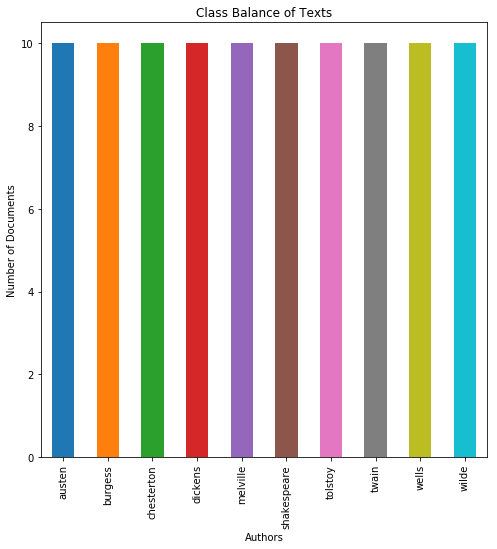

In [14]:
# Visualize Class imbalance
fig = plt.figure(figsize=(8,8))
df.groupby('author').text.count().plot.bar(ylim=0)
plt.title('Class Balance of Texts')
plt.xlabel('Authors')
plt.ylabel('Number of Documents')
plt.show()

## Feature Engineering: Tf-Idf Vectorizer

To create our features, we're going to use the TF-IDF vectorizer from sklearn. Our "documents" here are each of the texts. Since each of the novelists have unique and renowned styles of writing, the terms they use should differ significantly, especially Shakespeare.

In [15]:
# Create features
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', 
                        ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df['text'])
features_array = features.toarray()
labels = df['category_id']
features_array.shape

(100, 2994)

### Unigrams and Bigrams

Once we've created our features using tf-idf, we can calculate the chi-squared values for each feature and use that to determine the words, or set of two words (bigrams), that are most significant for identifying each author. Of course, the two most common words for Melville are "captain" and "whale", and for Shakespeare are "hath" and haue". One can intuitively see how the algorithm can differentiate between the authors.

In [16]:
# Pring the unigrams and bigrams for each label showing the most correlated words for each author
N = 2
for text, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features_array, labels == category_id)
    indices =np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' '))==1]
    bigrams = [v for v in feature_names if len(v.split(' '))==2]
    print("# '{}':".format(text))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:]))) 


# 'austen':
  . Most correlated unigrams:
. edward
. elizabeth
  . Most correlated bigrams:
. dear mr
. dare say
# 'burgess':
  . Most correlated unigrams:
. frog
. reddy
  . Most correlated bigrams:
. reddy fox
. peter rabbit
# 'chesterton':
  . Most correlated unigrams:
. ultimate
. philosophy
  . Most correlated bigrams:
. thing world
. looked like
# 'dickens':
  . Most correlated unigrams:
. accounts
. authorities
  . Most correlated bigrams:
. eyes like
. little man
# 'melville':
  . Most correlated unigrams:
. captain
. whale
  . Most correlated bigrams:
. day long
. round round
# 'shakespeare':
  . Most correlated unigrams:
. haue
. hath
  . Most correlated bigrams:
. thou art
. thou hast
# 'tolstoy':
  . Most correlated unigrams:
. soldiers
. christianity
  . Most correlated bigrams:
. went away
. tall man
# 'twain':
  . Most correlated unigrams:
. hotel
. dog
  . Most correlated bigrams:
. thousand miles
. new york
# 'wells':
  . Most correlated unigrams:
. coal
. machine
  . 

In [17]:
# Convert to Compressed Sparse Row (CSR) format
features_csr = features.tocsr()

# Create an empty similarity table for the texts
sim_table = pd.DataFrame(columns=np.arange(100), index = np.arange(100))

# Popularte the similarity table with the cosine similarity values
# Indices and columns correspond to the original list indices of the 105 texts
for i in range(len(sim_table.columns)):
    sim_table[i] = [(1 - spatial.distance.cosine(features_csr[i].toarray(), features_csr[j].toarray()))
                     for j in range(0,100)]
    
# Visualize similarity table containing cosine values
sim_table.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.174756,0.163797,0.149543,0.228071,0.124736,0.227913,0.294190,0.129529,0.186244,...,0.288862,0.258044,0.335944,0.123132,0.131128,0.172851,0.140736,0.111098,0.129556,0.112961
1,0.174756,1.000000,0.188997,0.105708,0.152530,0.127569,0.152198,0.165047,0.093593,0.198898,...,0.188977,0.139189,0.163194,0.090882,0.125112,0.116469,0.150251,0.296830,0.282389,0.113797
2,0.163797,0.188997,1.000000,0.130079,0.146052,0.105186,0.160221,0.158874,0.086626,0.176914,...,0.230821,0.125053,0.205018,0.199841,0.137519,0.158702,0.159837,0.142361,0.117324,0.093289
3,0.149543,0.105708,0.130079,1.000000,0.145430,0.092813,0.100203,0.147916,0.148366,0.182259,...,0.118211,0.123425,0.103094,0.077123,0.135589,0.119579,0.139948,0.066348,0.060946,0.112341
4,0.228071,0.152530,0.146052,0.145430,1.000000,0.159713,0.204553,0.219112,0.135916,0.160683,...,0.192315,0.207057,0.246321,0.086723,0.121146,0.178339,0.143317,0.139100,0.133655,0.146286


### Visualize Similarity Between Texts

Let's visualize how similar the texts are by calculating the cosine values of the angle between each of the vectors. Below, we populated a data frame with the cosine values between each text and used that information to generate a heatmap that can give us a sense of how similar each text is to another.

In [18]:
# Calculate vmax and vmin
col_maxes = [sim_table[i].sort_values(ascending=False).reset_index()[i][1] 
             for i in range(0, len(sim_table))]
v_max = np.max(col_maxes)

col_mins = [sim_table[i].sort_values(ascending=True)[0] for i in range(0, len(sim_table))]
v_min = np.min(col_mins)

print('vmax: {}'.format(v_max))
print('vmin: {}'.format(v_min))

vmax: 0.5562970560304841
vmin: 0.059977065120693784


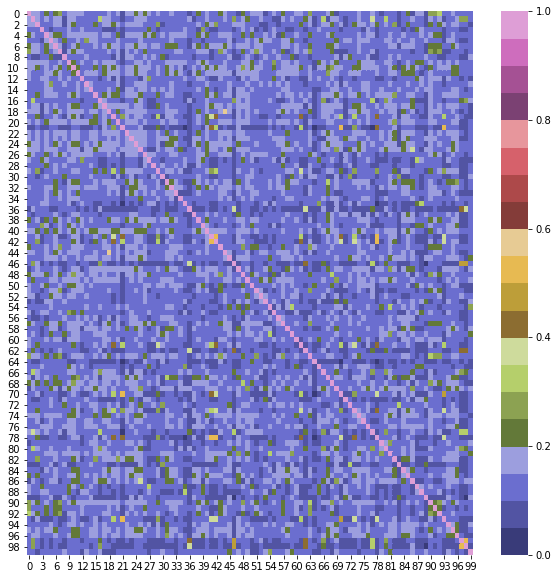

In [19]:
# Show heatmap for the correlation
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(sim_table, cmap="tab20b", vmin=0, vmax=1)
plt.show()

We can see from the heatmap that, in general, most texts do not correlate with one another. However, there are some "orange" squares representing the highest amount of similarities that are scattered around the map. Hopefully these squares represent the similarities between texts from the same author, especially those of Shakespeare.

# Multi-Class Text Classification: K-Means vs. Spectral Clustering

First, we're going to implement two clustering algorithms, k-means and spectral clustering, and evaluate their performance against each other. Then we'll choose the algorithm that performs the best and compare that to our supervised learning algorithms for classifying the texts.

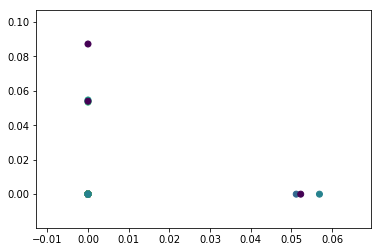

In [20]:
# Split into training and test set and create features using tfidf
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', 
                        ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df['text'])
features_array = features.toarray()
features_df = pd.DataFrame(features_array)
labels = df['category_id']

x_train, x_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.25, random_state=42)

# Impliment Kmeans algorithm on full data set
y_pred = KMeans(n_clusters=10, random_state=43).fit_predict(x_train)

# Plot the solution.
plt.scatter(x_train.values[:, 0], x_train.values[:, 1], c=y_pred)
plt.show()

In [21]:
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

Comparing k-means clusters against the data:
category_id  0  1  2  3  4  5  6  7  8  9
row_0                                    
0            0  0  0  0  0  6  0  0  0  1
1            0  0  1  0  5  0  1  1  0  1
2            0  0  2  0  0  0  1  0  0  1
3            0  8  0  0  0  0  0  0  0  0
4            7  0  0  0  1  0  1  3  0  0
5            0  0  1  3  2  0  1  3  0  0
6            0  0  0  0  0  3  1  0  0  1
7            0  0  1  0  0  0  3  0  0  2
8            0  0  2  3  0  0  0  1  0  1
9            0  0  0  0  0  0  0  0  7  0


In [22]:
# Compute Adjusted Rand Score (ARI) for kmeans on train set (to compare to Spectral Clustering)
metrics.adjusted_rand_score(y_pred, y_train)

0.3975815503143153

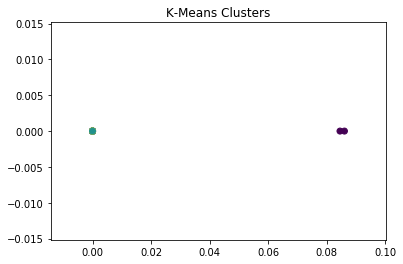

In [23]:
# Predict on hold-out group using kmeans
kmeans = KMeans(n_clusters=10, random_state=43).fit(x_train, y_train)
y_pred = kmeans.predict(x_test)

# Plot the solution.
plt.scatter(x_test.values[:, 0], x_test.values[:, 1], c=y_pred)
plt.title('K-Means Clusters')
plt.show()

In [24]:
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_test))

Comparing k-means clusters against the data:
category_id  0  1  2  3  4  5  6  7  8  9
row_0                                    
1            0  0  2  0  0  0  0  0  0  2
3            0  2  0  0  0  0  0  0  0  0
4            3  0  0  0  1  0  0  0  0  0
5            0  0  0  2  1  1  2  1  0  1
8            0  0  1  2  0  0  0  1  0  0
9            0  0  0  0  0  0  0  0  3  0


In [25]:
# Compute Adjusted Rand Score (ARI) for Kmeans on test set
print('ARI: ' + str(metrics.adjusted_rand_score(y_pred, y_test)))

ARI: 0.25773195876288657


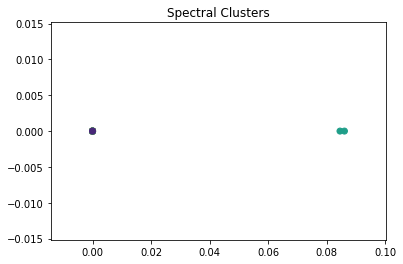

In [26]:
# Impliment Spectral Clustering
# define number of clusters to 10 clusters (number of authors/ labels)
n_clusters=10

# Declare and fit the model.
y_pred = SpectralClustering(n_clusters=n_clusters).fit_predict(x_test)

# Plot the solution.
plt.scatter(x_test.values[:, 0], x_test.values[:, 1], c=y_pred)
plt.title('Spectral Clusters')
plt.show()

In [27]:
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_test))

Comparing k-means clusters against the data:
category_id  0  1  2  3  4  5  6  7  8  9
row_0                                    
0            2  0  0  0  0  0  0  1  0  0
1            0  0  0  1  0  0  0  0  0  1
2            0  0  0  0  0  0  0  0  3  0
3            0  0  0  0  0  0  2  0  0  0
4            0  0  0  0  1  0  0  0  0  2
5            0  0  2  0  0  0  0  0  0  0
6            0  0  1  1  0  0  0  1  0  0
7            0  2  0  0  0  0  0  0  0  0
8            1  0  0  0  1  1  0  0  0  0
9            0  0  0  2  0  0  0  0  0  0


In [28]:
# Compute Adjusted Rand Score (ARI) for Spectral Clustering on train set (can't predict on test set)
print('ARI: ' + str(metrics.adjusted_rand_score(y_pred, y_test)))

ARI: 0.38566552901023887


### Conclusions from Clustering Algorithms

In general, the clustering algorithms performed poorly. If we look at the scatter plots, which show the centroids of the data points, we don't really gain too much information on the grouping of the features. Furthermore, the Adjusted Rand Indexes of both the K-means algorithm and spectral clustering algorithm are less than 0.5, indicating more randomness than their ability to find a similarity between the features. That being said, the spectral clustering algorithm performs better on the 25% test set, as its ARI is 0.386, than the k-means who's ARI is merely 0.258.
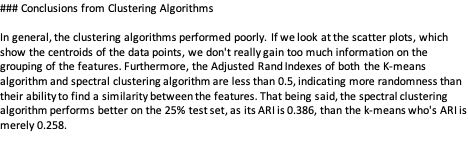

# Multi-Class Text Classification: Supervised Learning Models

We're now going to train 5 different supervised learning models on our data and compare their cross-validation scores to choose which algorithm classifies the text with the highest accuracy.

In [29]:
# Implimiment Multinomial Naive Bayes Classifier
clf = MultinomialNB().fit(x_train, y_train)
y_pred = clf.predict(x_test)

# Check the solution against the data
print('Crosstab matrix of predicted vs. Actual values:')
print(pd.crosstab(y_pred, y_test))

Crosstab matrix of predicted vs. Actual values:
category_id  0  1  2  3  4  5  6  7  8  9
row_0                                    
0            3  0  0  0  0  0  0  0  0  0
1            0  2  0  0  0  0  0  0  0  0
2            0  0  1  0  0  0  0  0  0  0
4            0  0  2  0  2  0  0  0  0  2
5            0  0  0  2  0  1  2  0  0  1
7            0  0  0  2  0  0  0  2  0  0
8            0  0  0  0  0  0  0  0  3  0


In [30]:
# Instantiate multiple Classifier models to compare
models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42), LinearSVC(), 
          MultinomialNB(), LogisticRegression(random_state=42), GradientBoostingClassifier(n_estimators=500, random_state=42)]

# Define holdout groups and dataframe to compare their accuracy scores
CV = 5
cv_df = pd.DataFrame(index=range(CV*len(models)))
entries = []

# Train and test each model on data for comparison
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features_array, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

# Populate the cross validation data frame to visualize comparison
cv_df = pd.DataFrame(entries, columns = ['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

In [31]:
# View mean accuracy scores of each model
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.60
1,RandomForestClassifier,1,0.65
2,RandomForestClassifier,2,0.60
3,RandomForestClassifier,3,0.90
4,RandomForestClassifier,4,0.65
5,LinearSVC,0,0.80
6,LinearSVC,1,0.90
7,LinearSVC,2,0.95
8,LinearSVC,3,0.95
9,LinearSVC,4,0.90


In [32]:
# View mean accuracy scores of each model
cv_df.groupby('model_name').accuracy.mean()

model_name
GradientBoostingClassifier    0.45
LinearSVC                     0.90
LogisticRegression            0.88
MultinomialNB                 0.85
RandomForestClassifier        0.68
Name: accuracy, dtype: float64

From all the models we've implemented, the Linear Support Vector Classifier performs with the highest accuracy on average across all hold-out groups at 90%. And although the model performs well consistently, our CV data frame shows one low out-lying accuracy score at 80%.

That being said, we're going to continue with the Linear SVC model and test it on our 25% hold-out group to see how it performs.

Accuracy: 0.88


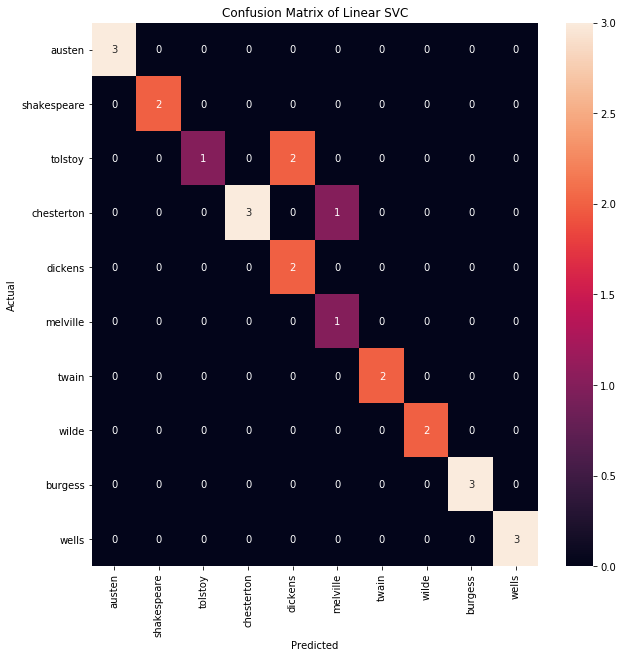

In [33]:
# Since Linear Support Vector Machine showed the best results, train and test the model on a 25% holdout group
model = LinearSVC()

x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(features_array, labels, df.index, test_size=0.25, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Accuracy
print('Accuracy: ' + str(model.score(x_test, y_test)))

# Visualize Confusion matrix on heatmap to see how well we classified the texts compared to the actual
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.author.values, yticklabels=category_id_df.author.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix of Linear SVC')
plt.show()

Above, we've generated a heatmap that represents a confusion matrix to visualize how often our model correctly classifies the text, with the prediction on the x-axis and the actual on the y-axis. As we can see, our model actually performs quite well since most of our predictions are on the diagonal. However, we wrongly predicted "Melville" once and "Dickens" twice as "Chesterton" and "Tolstoy" respectively. It's worth taking another look at these texts to see why that might be.

In [34]:
from IPython.display import display
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 1:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['author', 'text']])
            print('')

'tolstoy' predicted as 'dickens' : 2 examples.


,author,text
44,tolstoy,warden pressed door head woman disappeared i...
18,tolstoy,jailer ready comply order the jailer lock do...



'chesterton' predicted as 'melville' : 1 examples.


,author,text
69,chesterton,walked fought unknown fight and saw black tree...


In [35]:
# View accuracy scores on classifying each author (precission, recall, f1-score and support)
print(metrics.classification_report(y_test, y_pred, target_names=df['author'].unique()))

              precision    recall  f1-score   support

      austen       1.00      1.00      1.00         3
 shakespeare       1.00      1.00      1.00         2
     tolstoy       1.00      0.33      0.50         3
  chesterton       1.00      0.75      0.86         4
     dickens       0.50      1.00      0.67         2
    melville       0.50      1.00      0.67         1
       twain       1.00      1.00      1.00         2
       wilde       1.00      1.00      1.00         2
     burgess       1.00      1.00      1.00         3
       wells       1.00      1.00      1.00         3

   micro avg       0.88      0.88      0.88        25
   macro avg       0.90      0.91      0.87        25
weighted avg       0.94      0.88      0.88        25



To further evaluate our model’s performance, the above table shows us the precision, recall, f1-score and support values for predicting the text to each author. We can see that our model performs well over-all, however certain classes are predicted poorly. For example, predicting "Tolstoy" has an especially poor recall value at 33%, meaning that it only correctly predicted 33% of the "Tolstoy" texts present in the model. "Dickens" and "Melville" also show poor precision values at 50%, meaning that our model predicted "False Positives" about half the time.

# Conclusions

From our investigation I can conclude that the clustering algorithms performed far worse than any of the supervised learning models in classifying our texts to correct authors. The Adjusted Rand Index for both Spectral Clustering and the K-means algorithm were both below 0.5, indicating more randomness in their prediction than agreement between predicted and actual.

To improve the performance of the clustering algorithms, it may require a larger and more diverse dataset that we can train the models on so that the algorithm can decide on more distinct centroids to group the features around. If we had less classes or authors and more texts, for example 5 authors with 100 texts, then the algorithm has more data to for each centroid to group the data points around and differentiate the groups more distinctly. However, at only 10 texts per author with 100 authors, it's likely not enough information for the clusters to define their boundaries.

Our Linear Support Vector Classifier, on the other hand, performed extremely well on our test group. It classifies our texts with 88% accuracy. Our cross-validation average score is 90%. Our precision is 94% and both recall and f1-scores on average at 88% as well. So, this model is also consistent in its predictions, and reliable for use in identifying new texts written by the same authors. 

One limitation of the Linear SVC model is its tendency to over-fit, however, we've seen from our accuracy on our cross-validation and 25% hold-out group, the model seems to handle well when provided with new information. Another limitation is the size and diversity of our dataset. Although 100 documents are quite a large corpus for training modelling. We only have 10 documents per author. Furthermore, all of the texts are novels, so there isn't much diversity in the texts. If we want to more accurately determine whether an author wrote a piece of text or not, we should different types of inputs by the same authors so that the model can make predictions on different types of texts, such as short-stories, memoirs. If implemented the model on modern authors, we can train the model on social media posts and blogs as well. Finally, the 6,000 to the 18,000 character was used as a representative sample, instead of the whole text. If we had more computing power, we should train our model on the text.